In [27]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### description

- stock_id - A unique identifier for the stock. Not all stock IDs exist in every time bucket.

- date_id - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.

- imbalance_size - The amount unmatched at the current reference price (in USD).

- imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.
    - buy-side imbalance; 1
    - sell-side imbalance; -1
    - no imbalance; 0

- reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.

- matched_size - The amount that can be matched at the current reference price (in USD).

- far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.

- near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders.

- [bid/ask]_price - Price of the most competitive buy/sell level in the non-auction book.

- [bid/ask]_size - The dollar notional amount on the most competitive buy/sell level in the non-auction book.

- wap - The weighted average price in the non-auction book.
$$
\frac{BidPrice * AskSize + AskPrice * BidSize}{BidSize + AskSize}
$$

- seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.

- target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
Where t is the time at the current observation, we can define the target:
$$
Target = \left(\frac{StockWAP_{t+60}}{StockWAP_t} - \frac{IndexWAP_{t+60}}{IndexWAP_t}\right) * 10000
$$

All size related columns are in USD terms.

All price related columns are converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.

sample_submission A valid sample submission, delivered by the API. See this notebook for a very simple example of how to use the sample submission.

revealed_targets When the first time_id for each date (i.e. when seconds_in_bucket equals zero) the API will serve a dataframe providing the true target values for the entire previous date. All other rows contain null values for the columns of interest.

public_timeseries_testing_util.py An optional file intended to make it easier to run custom offline API tests. See the script's docstring for details. You will need to edit this file before using it.

example_test_files/ Data intended to illustrate how the API functions. Includes the same files and columns delivered by the API. The first three date ids are repeats of the last three date ids in the train set, to enable an illustration of how the API functions.

optiver2023/ Files that enable the API. Expect the API to deliver all rows in under five minutes and to reserve less than 0.5 GB of memory. The first three date ids delivered by the API are repeats of the last three date ids in the train set, to better illustrate how the API functions. You must make predictions for those dates in order to advance the API but those predictions are not scored.

In [2]:
input_dir_path = pathlib.Path('../inputs')

### load train dataset

In [3]:
train_df = pd.read_csv(input_dir_path.joinpath('train.csv'))
display(train_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [4]:
train_df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

<Axes: xlabel='stock_id'>

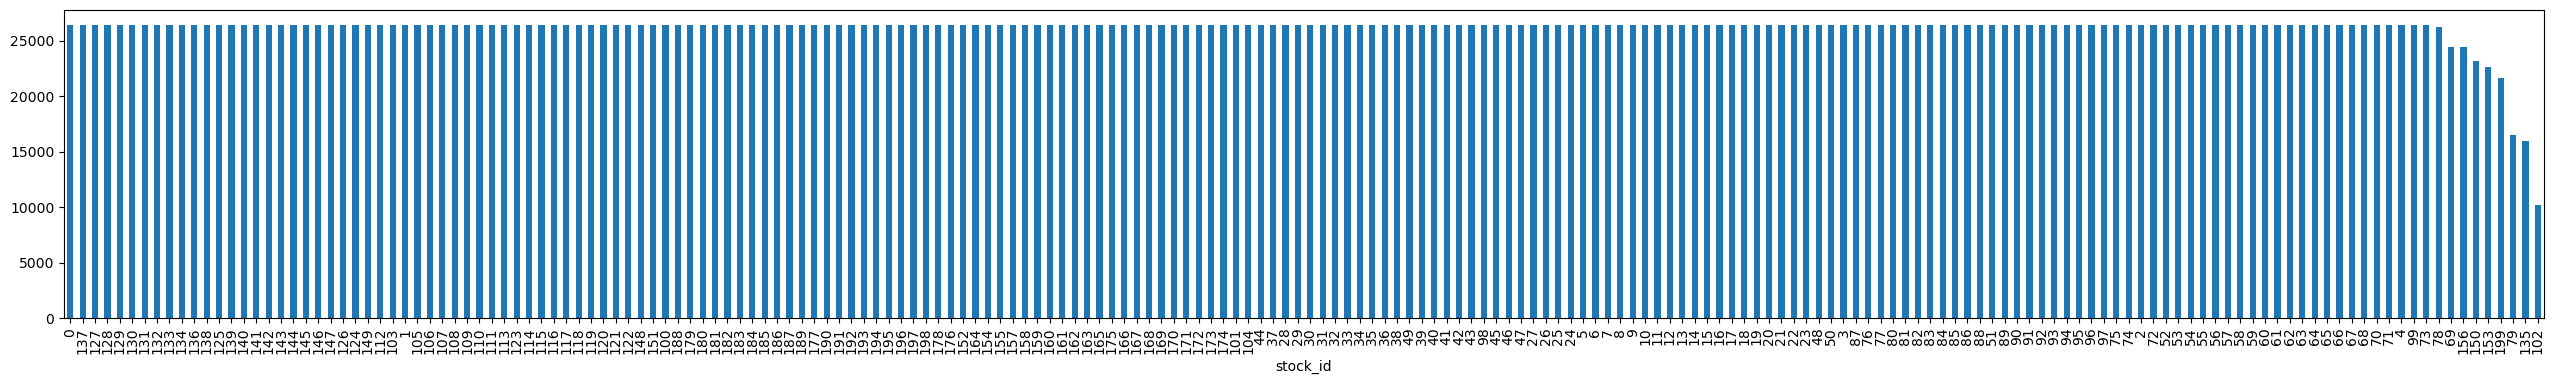

In [11]:
train_df['stock_id'].value_counts().plot.bar(figsize=(32, 4))

In [20]:
value_counts_per_date = train_df.groupby(['stock_id', 'date_id']).size().unstack(fill_value=0)
value_counts_per_date['Total'] = value_counts_per_date.sum(axis=1)
display(value_counts_per_date)
display(value_counts_per_date.query('Total!=26455'))

date_id,0,1,2,3,4,5,6,7,8,9,...,472,473,474,475,476,477,478,479,480,Total
stock_id,,,,,,,,,,,,,,,,,,,,,
0,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,26455
1,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,26455
2,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,26455
3,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,26455
4,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,26455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,26455
196,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,26455
197,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,26455


date_id,0,1,2,3,4,5,6,7,8,9,...,472,473,474,475,476,477,478,479,480,Total
stock_id,,,,,,,,,,,,,,,,,,,,,
69,0,0,0,0,0,0,0,0,0,0,...,55,55,55,55,55,55,55,55,55,24420
73,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,26400
78,0,0,0,0,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,26235
79,0,0,0,0,0,0,0,0,0,0,...,55,55,55,55,55,55,55,55,55,16500
99,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,26400
102,0,0,0,0,0,0,0,0,0,0,...,55,55,55,55,55,55,55,55,55,10230
135,0,0,0,0,0,0,0,0,0,0,...,55,55,55,55,55,55,55,55,55,15950
150,0,0,0,0,0,0,0,0,0,0,...,55,55,55,55,55,55,55,55,55,23210
153,0,0,0,0,0,0,0,0,0,0,...,55,55,55,55,55,55,55,55,55,22605


array([[<Axes: title={'center': 'stock_id'}>,
        <Axes: title={'center': 'date_id'}>,
        <Axes: title={'center': 'seconds_in_bucket'}>,
        <Axes: title={'center': 'imbalance_size'}>],
       [<Axes: title={'center': 'imbalance_buy_sell_flag'}>,
        <Axes: title={'center': 'reference_price'}>,
        <Axes: title={'center': 'matched_size'}>,
        <Axes: title={'center': 'far_price'}>],
       [<Axes: title={'center': 'near_price'}>,
        <Axes: title={'center': 'bid_price'}>,
        <Axes: title={'center': 'bid_size'}>,
        <Axes: title={'center': 'ask_price'}>],
       [<Axes: title={'center': 'ask_size'}>,
        <Axes: title={'center': 'wap'}>,
        <Axes: title={'center': 'target'}>,
        <Axes: title={'center': 'time_id'}>]], dtype=object)

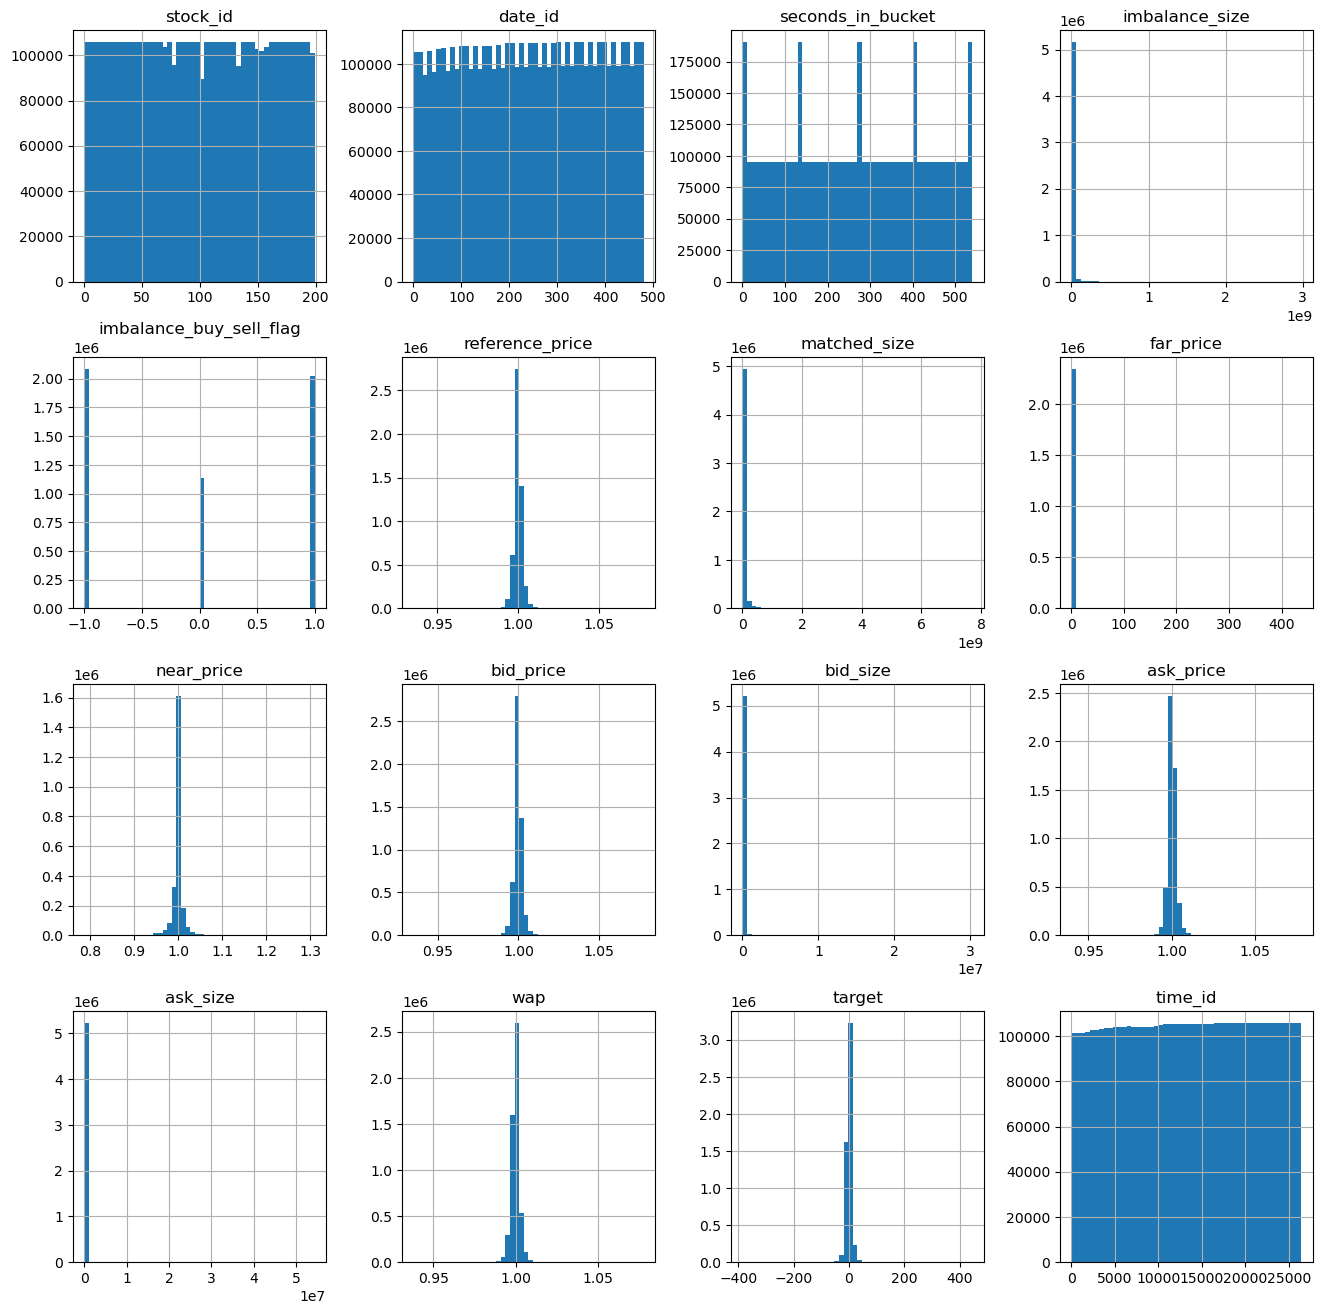

In [5]:
train_df.hist(bins=50, figsize=(16, 16))

In [21]:
display(train_df.dtypes)
display(train_df.describe())

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
far_price                  float64
near_price                 float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
target                     float64
time_id                      int64
row_id                      object
dtype: object

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [38]:
print(f'# of unique stock_id: {train_df["stock_id"].nunique()}')
print(f'# of unique date_id: {train_df["date_id"].nunique()}')

# of unique stock_id: 200
# of unique date_id: 481


### difference between ask price and bid price

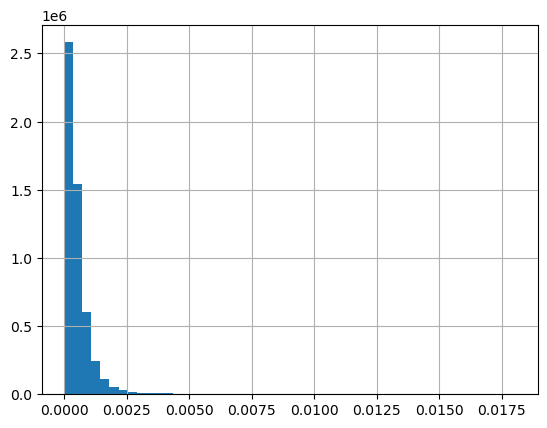

count    5.237760e+06
mean     5.382061e-04
std      5.831490e-04
min      3.000000e-06
25%      2.150000e-04
50%      3.690000e-04
75%      6.560000e-04
max      1.804300e-02
dtype: float64

In [30]:
diff_ask_bid_price = train_df['ask_price'] - train_df['bid_price']

diff_ask_bid_price.hist(bins=50)
plt.show()

display(diff_ask_bid_price.describe())

### difference between ask size and bid size

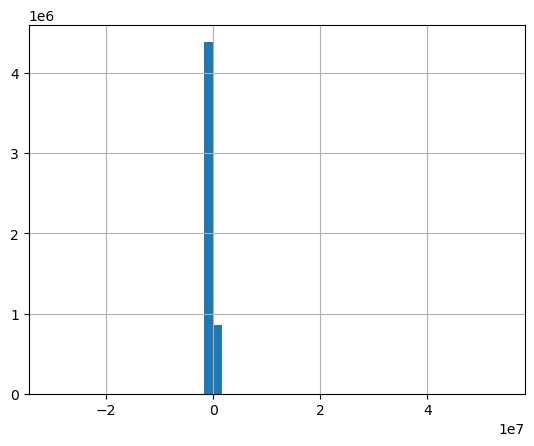

count    5.237980e+06
mean     1.762090e+03
std      1.453429e+05
min     -3.027992e+07
25%     -1.994511e+04
50%      1.891000e+02
75%      2.210972e+04
max      5.394155e+07
dtype: float64

In [39]:
diff_ask_bid_size = train_df['ask_size'] - train_df['bid_size']

diff_ask_bid_size.hist(bins=50)
plt.show()

display(diff_ask_bid_size.describe())

### load test dataset

In [32]:
test_dataset = pd.read_csv(input_dir_path.joinpath('example_test_files/test.csv'))
display(test_dataset)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.000000,26290,478_0_0
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.000000,26290,478_0_1
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.000000,26290,478_0_2
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.000000,26290,478_0_3
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.000000,26290,478_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,26454,480_540_195
32996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,26454,480_540_196
32997,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,26454,480_540_197
32998,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,26454,480_540_198
